In [6]:
import numpy as np
import seaborn as sns
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

G = 6.67e-11
c = 2.998e8
Msun = 2e30
Rsun = 7e8
year = 3600.*24.*365
kpc = 1e3*3.086e16

Let's define the LISA PSD. I'll follow Eq. 1 of [Robson et al](https://arxiv.org/pdf/1803.01944.pdf)

/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


Text(0, 0.5, 'PSD')

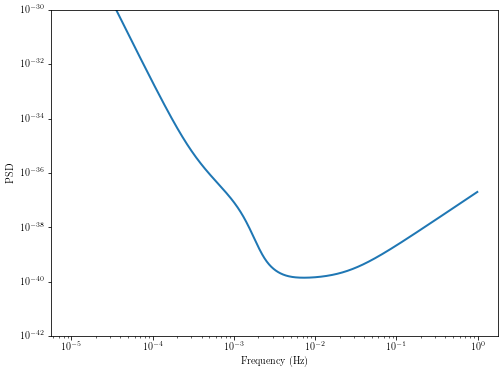

In [7]:
# https://arxiv.org/pdf/1803.01944.pdf

L_arm = 2.5e9
fref = 19.09e-3
def LISA_sensitivity(f):
    
    # Instrumental noise
    P_oms = np.power(1.5e-11,2.)*(1.+np.power(2.e-3/f,4.))
    P_acc = np.power(3.e-15,2.)*(1.+np.power(0.4e-3/f,2.))*(1.+np.power(f/8e-3,4))
    #P_n = P_oms/L_arm**2. + 2.*(1.+np.cos(f/fref)**2.)*P_acc/(np.power(2.*np.pi*f,4.)*L_arm**2.)    
    S_n = (10./(3.*L_arm*L_arm))*(P_oms + 4.*P_acc/np.power(2.*np.pi*f,4.))*(1.+(3./5.)*np.power(f/fref,2.))
    
    # Confusion noise (assume four years)
    A = 9e-45
    alpha = 0.138
    beta = -221.
    k = 521.
    gamma = 1680.
    fk = 1.13e-3
    S_conf = A*np.power(f,-7./3.)*np.exp(-f**alpha+beta*f*np.sin(k*f))*(1.+np.tanh(gamma*(fk-f)))
    
    S_n[f>=1.] = np.inf
    S_conf[f>=1.] = np.inf
    
    return S_n + S_conf

f = np.logspace(-5,2,1000)
strain_sensitivity = LISA_sensitivity(f)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(f,strain_sensitivity,lw=2)
#ax.plot(f,confusion,lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-42,1e-30)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

NameError: name 'confusion' is not defined

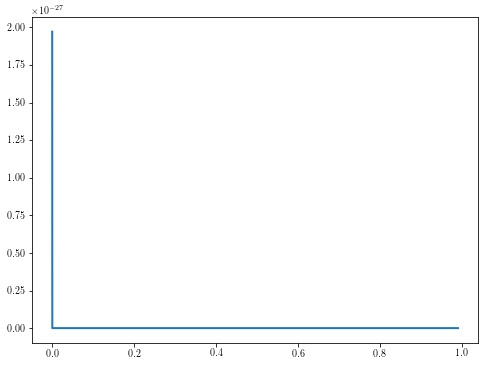

NameError: name 'confusion' is not defined

In [8]:
def f_from_a(mtot,a):
    return np.sqrt(G*mtot*Msun/(a*Rsun)**3)/(2.*np.pi)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(f,strain_sensitivity,lw=2)
ax.plot(f,confusion,lw=2)
ax.axvline(x=f_from_a(1.,1.))
ax.axvline(x=f_from_a(1.,0.3))
ax.axvline(x=f_from_a(1.,0.1))
#ax.annotate('test',xy=(1e-4,1e-40),rotate=90)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-42,1e-30)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

Averaging over sky position and binary inclination angles, the mean squared-SNR of a binary signal is

\begin{equation}
\langle \mathrm{SNR}\rangle^2 = \frac{16}{5} \int_0^\infty \frac{A^2(f)}{S_n(f)} df,
\end{equation}

where $A(f)$ is the amplitude of the strain signal and $S_n(f)$ is our total strain sensitivity given above. Caution -- $S_n(f)$ is *not* the PSD, but the PSD divided by the LISA transfer function.

Consider a toy binary with chirp mass $\mathcal{M}_c$ at distance $D$. Neglecting evolution, the gravitational-wave signal will have form

\begin{equation}
h(t) = \frac{4}{D} \left(\frac{G \mathcal{M}_c}{c^2} \right)^{5/3} \left(\frac{2\pi f_\mathrm{orb}}{c}\right)^{2/3} \cos(2\pi f_\mathrm{orb} t)
\end{equation}

Using Kepler's third law, this becomes

\begin{equation}
h(t) = \frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2 \cos(2\pi f_\mathrm{orb} t),
\end{equation}

where $a$ is the binary's semimajor axis and $M$ its total mass.
In the Fourier domain, we have

\begin{equation}
\boxed{A(f) = \frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2 \delta(f-2 f_\mathrm{orb})}
\end{equation}

Strictly speaking, this isn't a true delta function, but a "finite-time" delta function that evaluates to $\delta(0) = T$, the total observation time ($1/T$ is our maximum frequency resolution).
When substituting $A(f)$ into our SNR equation above, we'll let one of our two delta functions act as a finite time $delta$, giving

\begin{equation}
\begin{aligned}
\langle \mathrm{SNR}\rangle^2 &= \frac{16}{5} \left[\frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2\right]^2
        \int_0^\infty \frac{\delta^2(f-2f_\mathrm{orb})}{S_n(f)} df \\
    &= \frac{256}{5} \left(\frac{\eta}{a D}\right)^2 \left(\frac{G M}{c^2}\right)^4 T
        \int_0^\infty \frac{\delta(f-2f_\mathrm{orb})}{S_n(f)} df \\
    &= \frac{256}{5} \left(\frac{\eta}{a D}\right)^2 \left(\frac{G M}{c^2}\right)^4 \frac{T}{S_n(2f_\mathrm{orb})}
\end{aligned}
\end{equation}

In [9]:
def kepler_f(a_orb,m_comp):
    M = 2.*m_comp*Msun
    f_orb = np.sqrt(G*M/(4.*np.pi**2.*(a_orb*Rsun)**3.))
    return f_orb

def h(a_orb,m_comp,dist):
    
    # Assume equal mass
    eta = 0.25
    M = 2.*m_comp*Msun
    
    h = (4./(dist*kpc))*(eta/(a_orb*Rsun))*np.power(G*M/c**2.,2.)
    return h

def SNR(a_orb,m_comp,dist):
    
    # Assume four year observation, equal mass
    T = 5*year
    eta = 0.25
    M = 2.*m_comp*Msun
    
    # Get orbital frequency from Kepler and evaluate sensitivity curve
    f_orb = np.sqrt(G*M/(4.*np.pi**2.*(a_orb*Rsun)**3.))
    Sn = LISA_sensitivity(2.*f_orb)
    
    SNR2 = (256./5.)*np.power(eta/(a_orb*Rsun*dist*kpc),2.)*np.power(G*M/c**2.,4.)*T/Sn
    return np.sqrt(SNR2)

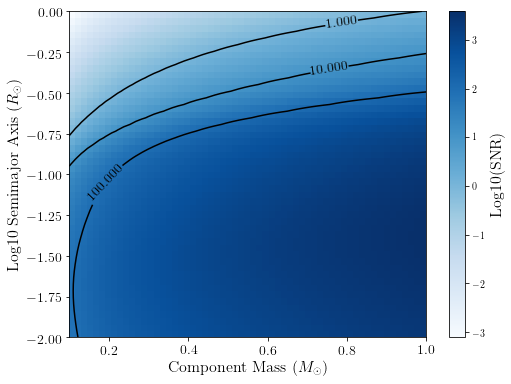

In [10]:
a_orbs = np.linspace(-2.,0,50)
m_comp = np.linspace(0.1,1,60)
M_COMP,A_ORB = np.meshgrid(m_comp,a_orbs)
rhos = SNR(10.**A_ORB,M_COMP,3)

fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(m_comp,a_orbs,np.log10(rhos),cmap='Blues')
CS = ax.contour(m_comp,a_orbs,rhos,levels=[1,10,100],colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'Component Mass ($M_\odot$)',fontsize=16)
ax.set_ylabel(r'Log10 Semimajor Axis ($R_\odot$)',fontsize=16)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
plt.savefig('./SNRs.pdf')

In [11]:
def snr_from_a_adot(a0,adot):
    
    a0 = Rsun*a0
    adot = adot*Rsun/year

    # Separation (s)
    D = 3*kpc
    a_final = max(0.0*Rsun,a0+adot*5.*year)

    # Binary mass
    kg_to_sec = G/c**3.
    m = 1.*Msun

    # GW frequencies
    f0 = (1./np.pi)*np.sqrt(G*m/a0**3.)
    if a_final==0:
        f_final = 10.
    else:
        f_final = (1./np.pi)*np.sqrt(G*m/a_final**3.)
    
    # Get fourier-domain amplitudes
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/100.)
    amp_at_f = (4./D)*np.power(G*Msun/c**2.,5./3.)*np.power(np.pi*fourier_freqs/c,2./3.)
    sep_at_f = np.power(G*Msun/(np.pi*fourier_freqs)**2,1./3.)
    fdot_at_f = -(3./(2.*np.pi))*np.sqrt(G*Msun)*np.power(sep_at_f,-5./2.)*(adot)
    hf = amp_at_f/np.sqrt(fdot_at_f)

    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)
    
    return np.sqrt(rho2)/4

def snr_from_f_fdot(f0,fdot0):
    
    if f0>=1.:
        return 0.

    # Binary mass
    m = 1.*Msun    
    fdot0 = fdot0/year
    f_final = min(1.,f0+fdot0*1.*year)
    
    #print((f_final-f0)/fdot0/year)
    
    #a0 = np.power(G*m/(np.pi*f0)**2.,1./3.)
    #adot = -(2.*np.pi/3.)*fdot0*np.power(a0,5./2.)/np.sqrt(G*m)
    #a_final = max(0.0*Rsun,a0+adot*5.*year)

    # Separation (s)
    D = 3*kpc

    # Get fourier-domain amplitudes
    #if a_final==0:
    #    f_final = 10.
    #else:
    #    f_final = (1./np.pi)*np.sqrt(G*m/a_final**3.)
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/1000.)
    amp_at_f = (4./D)*np.power(G*m/c**2.,5./3.)*np.power(np.pi*fourier_freqs/c,2./3.)
    sep_at_f = np.power(G*m/(np.pi*fourier_freqs)**2,1./3.)
    adot = (-2.*np.pi/3.)*fdot0*np.power(sep_at_f,5./2.)/np.sqrt(G*m)
    #fdot_at_f = -(3./(2.*np.pi))*np.sqrt(G*m)*np.power(sep_at_f,-5./2.)*(adot)
    fdot_at_f = fdot0
    hf = amp_at_f/np.sqrt(fdot_at_f)
    
    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)

    return np.sqrt(rho2)/4

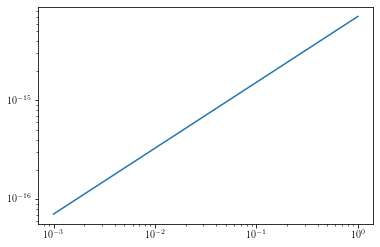

In [12]:
f0 = 1e-3
fdot = 1e-3/year
f_final = 1
fourier_freqs = np.arange(f0,f_final,(f_final-f0)/1000.)

m = Msun
D = 3.*kpc

amp_at_f = (4./D)*np.power(G*m/c**2.,5./3.)*np.power(np.pi*fourier_freqs/c,2./3.)
sep_at_f = np.power(G*m/(np.pi*fourier_freqs)**2,1./3.)
adot = (-2.*np.pi/3.)*fdot*np.power(sep_at_f,5./2.)/np.sqrt(G*m)
fdot_at_f = fdot
hf = amp_at_f/np.sqrt(fdot_at_f)

fig,ax = plt.subplots()
ax.plot(fourier_freqs,hf)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

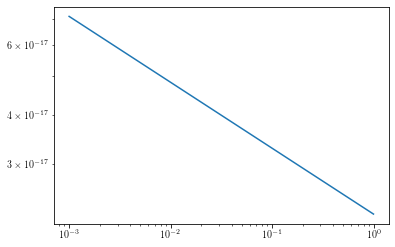

In [13]:
f0 = 1e-3
fdot0 = 1e-3/year
a0 = np.power(G*m/(np.pi*f0)**2.,1./3.)
adot = -(2.*np.pi/3.)*fdot0*np.power(a0,5./2.)/np.sqrt(G*m)
a_final = max(0.0*Rsun,a0+adot*5.*year)

# Separation (s)
D = 3*kpc

fourier_freqs = np.arange(f0,f_final,(f_final-f0)/1000.)
amp_at_f = (4./D)*np.power(G*m/c**2.,5./3.)*np.power(np.pi*fourier_freqs/c,2./3.)
sep_at_f = np.power(G*m/(np.pi*fourier_freqs)**2,1./3.)
fdot_at_f = -(3./(2.*np.pi))*np.sqrt(G*m)*np.power(sep_at_f,-5./2.)*(adot)
hf = amp_at_f/np.sqrt(fdot_at_f)

fig,ax = plt.subplots()
ax.plot(fourier_freqs,hf)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


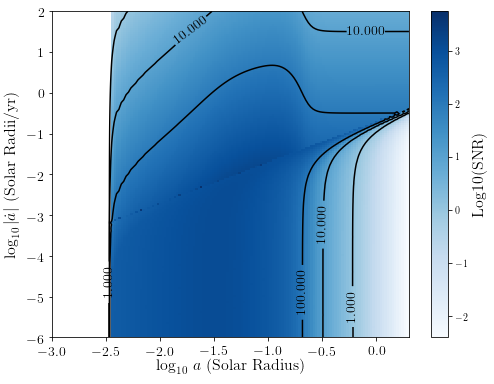

In [14]:
a_orbs = np.linspace(-3.,0.3,150)
adot_orbs = np.linspace(-6,2,160)
rhos = np.zeros((a_orbs.size,adot_orbs.size))
for i in range(a_orbs.size):
    for j in range(adot_orbs.size):
        rhos[i,j] = snr_from_a_adot(10.**a_orbs[i],-10.**adot_orbs[j])

fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(a_orbs,adot_orbs,np.log10(rhos).T,cmap='Blues')
CS = ax.contour(a_orbs,adot_orbs,rhos.T,levels=[1,10,100],colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'$\log_{10} \,a$ (Solar Radius)',fontsize=16)
ax.set_ylabel(r'$\log_{10} |\dot a|$ (Solar Radii/yr)',fontsize=16)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
#plt.savefig('./SNRs.pdf')


In [181]:
c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)
solar_mass_gr = 1.989e33
secs_in_pc = 102927133.01 #about 1e8 s per pc

def mchirp(m1,m2): return ((mu(m1,m2))**(3./5))*((M(m1,m2))**(2./5))  # chirp mass


# Mass functions

def mu(m1,m2): return s_mass*(m1*m2)/(m1+m2) # reduced mass

def M(m1,m2):  return s_mass*(m1+m2) # total mass


def soundSpeed(Temp):
    """
    This is the sound speed, c_s, where c_s^2 = k_B*T/m_p
    Returns dimensionless quantity. To get physical units, multiply by c.
    """
    kbTemp_GR = 3.80526e-76*Temp # seconds, for 1K
    mProton = 4.14324e-63 #seconds
    ans = kbTemp_GR/mProton
    return sqrt(ans)

def fdot_gw_mod(m1,m2,fgw):
    const = 96./5*pi**(8./3)
    num = (mchirp(m1,m2))**(5./3)*fgw**(11./3)
    ans = num*const
    return ans

def fdot_drag(m1,m2,temperature, Const, fgw):
    rho_0=1e-6*(1e-3)/(0.01)**3 # cm -> m
    num = 2*rho_0*Const*3*(6.67428*(10**(-11)))**(5/3.)*((m1+m2)*2e30)**(2/3.)*fgw**(2./3)
    deno = (soundSpeed(temperature)*c)**2*2*pi**(1/3.)
    ans = num/deno
    return ans

gw_vec = []
drag_vec = []
xax = []
m1=1
m2=1
temperature = 1e5
Const=1

for qq in range (1,1000):
    qq=qq/1000
    xax.append(qq)
    gw_vec.append(fdot_gw_mod(m1,m2,qq))
    drag_vec.append(fdot_drag(m1,m2,temperature, Const, qq))

NameError: name 'sqrt' is not defined

/Users/tcallister/miniconda3/envs/work-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


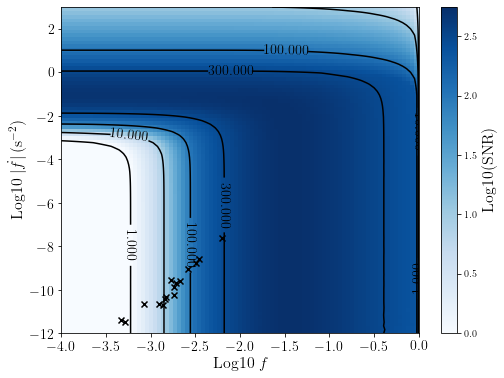

In [177]:
f_orbs = np.linspace(-4.,0,90)
fdot_orbs = np.linspace(-12,3,90)
rhos = np.zeros((f_orbs.size,fdot_orbs.size))
for i in range(f_orbs.size):
    for j in range(fdot_orbs.size):
        rhos[i,j] = snr_from_f_fdot(10.**f_orbs[i],10.**fdot_orbs[j])

fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(f_orbs,fdot_orbs,np.log10(rhos).T,cmap='Blues',vmin=0)
CS = ax.contour(f_orbs,fdot_orbs,rhos.T,levels=[1,10,100,300],colors='black')
#ax.plot(f_orbs,fdot_orbs)
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'Log10 $f$',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|\,(\mathrm{s}^{-2})$',fontsize=16)
ax.scatter(np.log10(wd_fs),np.log10((96./5.)*np.power(np.pi,8./3.)*np.power(c,-5.)*np.power(G*Mc*Msun,5./3.)*np.power(wd_fs,11./3.)*year),marker='x',color='black')
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)

In [163]:
wd_fs = np.array([6.22,3.51,3.22,2.12,1.94,1.84,1.81,1.48,1.45,1.36,1.25,2.61,1.68,0.84,0.51,0.47])*1e-3
m1s = np.array([0.55,0.8,0.8,0.8,0.68,0.8,0.65,0.8,0.8,0.9,0.9,0.25,0.3,0.3,0.3,0.5])
m2s = np.array([0.27,0.18,0.16,0.1,0.13,0.09,0.05,0.07,0.06,0.04,0.06,0.5,0.75,0.75,0.75,0.8])

etas = m1s*m2s/(m1s+m2s)**2.
Mc = np.power(etas,3./5.)*(m1s+m2s)

In [166]:
(96./5.)*np.power(np.pi,8./3.)*np.power(c,-5.)*np.power(G*0.39*Msun,5./3.)*np.power(0.015,11./3.)

2.497917501535786e-14

# 